In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Flatten
import psutil

In [2]:
!pip install memory-profiler
from memory_profiler import memory_usage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
path='/content/drive/MyDrive/Colab Notebooks/Mat.1.csv'
df=pd.read_csv(path)

In [4]:
df

,Job samples,CPU,Memory,Reward,CPU used,Memory used
0,10,60,100,NaN,NaN,NaN
1,15,50,160,NaN,NaN,NaN
2,13,65,200,NaN,NaN,NaN
3,16,55,140,NaN,NaN,NaN
4,8,78,220,NaN,NaN,NaN
5,11,80,260,NaN,NaN,NaN
6,2,62,140,NaN,NaN,NaN
7,17,54,180,NaN,NaN,NaN
8,12,65,340,NaN,NaN,NaN
9,9,66,280,NaN,NaN,NaN


In [5]:
class env:
    rand_seed = 10
    def __init__(self, resources, num_tasks):
        np.random.seed(self.rand_seed)
        self.state_ = np.zeros((num_tasks, 1), dtype=int)
        self.limit_ = 0
        for lim in resources:
            self.state_ = np.append(self.state_, np.random.randint(lim, size=(num_tasks, 1)), axis=1)    
        self.reward_ = 0
        for lim in resources:
            self.limit_+=lim         
        self.num_tasks_ = num_tasks
        self.resources_ = resources   
    def get_initial_state(self):
        state = np.zeros((self.num_tasks_, len(self.resources_) + 1), dtype=int)
        for lim in self.resources_: 
            state = np.append(state, np.random.randint(lim, size=(self.num_tasks_,1)), axis=1)
        self.state_ = state
        self.reward_ = 0
        return self.state_
    def getSum(self, x ):
        if x[0] == 1:
            return sum(x)-1
        else:
            return 0
    def get_next_step(self, actionIdx):        
        self.reward_ = 0
        reward = 0
        done = False        
        if self.state_[actionIdx][0] == 1:
            sum_res = np.sum(self.state_[actionIdx], axis=0)
            reward = -sum_res/10;
        else:
            self.state_[actionIdx][0] = 1        
        totReward = sum(np.apply_along_axis( self.getSum, axis=1, arr=self.state_ ))
        sum_res = np.sum(self.state_[actionIdx], axis=0) 
        if totReward <= self.limit_:
            reward = sum_res
        else:
            reward = -sum_res/10;
            done = True
        return self.state_,reward,done 
xyz = []
xyz1 = []
xyz2 = []
Job = df['Job samples'].sort_values().tolist()
Lcpu = df['CPU'].sort_values().tolist()
Lmemory = df['Memory'].sort_values().tolist()
df['Job samples'] = Job
df['CPU']=Lcpu
df['Memory']=Lmemory
# job_samples_sorted_indices = np.argsort(df.iloc[:,0])
# CPU_sorted_indices = np.argsort(df.iloc[:,1])
# Memory_sorted_indices = np.argsort(df.iloc[:,2])
for j in range(df.shape[0]):
  resources = [df.iat[j, 1], df.iat[j, 2]]
  num_tasks = 5
  en = env(resources,num_tasks)
  mem_usage_before = memory_usage(-1, interval=1)[0]
  cpu_usage_before = psutil.cpu_percent(interval=None)
  input_layer_n = num_tasks
  output_layer_n = 5
  dense_layer_n = 10
  model = Sequential()
  model.add(Flatten(input_shape=(5, 5)))
  model.add(InputLayer(batch_input_shape=(1, len(resources) + 1)))
  model.add(Dense(dense_layer_n, activation='sigmoid'))
  model.add(Dense(output_layer_n, activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  num_job_samples = df.iat[j, 0]
  y = 0.95
  eps = 0.5
  decay_factor = 0.999
  r_avg_list = []
  for i in range(num_job_samples):
      s = en.get_initial_state()
      eps *= decay_factor
      if i % 100 == 0:
          print("Episode {} of {}".format(i + 1, num_job_samples))
      scheduled = False
      r_sum = 0
      while not scheduled:
          if np.random.random() < eps:
              a = np.random.randint(0, 5) 
          else:
              s_expanded = np.expand_dims(s, axis=0)  # add extra dimension to match model input shape
              q_values = model.predict(s_expanded)[0]  # get Q-values for all actions
              a = np.argmax(q_values)  # choose action with highest Q-value
          new_s, r, scheduled = en.get_next_step(a) 
          target = r + y * np.max(model.predict(np.expand_dims(new_s, axis=0)))  # add extra dimension to match model input shape
          target_vec = model.predict(np.expand_dims(s, axis=0))[0]  # get Q-values for current state
          target_vec[a] = target
          model.fit(np.expand_dims(s, axis=0), np.expand_dims(target_vec, axis=0), epochs=1, verbose=0)  # add extra dimension to match model input shape
          s = new_s
          r_sum += r
      r_avg_list.append(r_sum / num_tasks)
      print("Total reward for episode {}: {}".format(i + 1, r_sum))
  k=sum(r_avg_list) / len(r_avg_list)
  xyz.append(k)
  df.iat[j, 3] = k 
  mem_usage_after = memory_usage(-1, interval=1)[0]
 
  cpu_usage_after = psutil.cpu_percent(interval=None)
  mem=mem_usage_after-mem_usage_before
  cpu=cpu_usage_after-cpu_usage_before
  xyz1.append(cpu)
  df.iat[j, 4] = cpu
  xyz2.append(mem)
  df.iat[j, 5] = mem
  print(f"Memory usage (Iteration {j}): {mem_usage_after-mem_usage_before}MiB")
  print(f"CPU usage (Iteration {j}): {cpu_usage_after-cpu_usage_before}%")
  print("Average reward per task after {} episodes: {}".format(num_job_samples, sum(r_avg_list) / len(r_avg_list)))
  sorted_indices = np.argsort(df['Job samples'])
  df_sorted = df.iloc[sorted_indices].copy()

Episode 1 of 1
1/1 [==============================] - 0s 42ms/step
Total reward for episode 1: 86.1
Memory usage (Iteration 0): 37.5859375MiB
CPU usage (Iteration 0): 64.2%
Average reward per task after 1 episodes: 17.22
Episode 1 of 2
1/1 [==============================] - 0s 22ms/step
Total reward for episode 1: 234.1
1/1 [==============================] - 0s 22ms/step
Total reward for episode 2: 84.0
Memory usage (Iteration 1): 14.16015625MiB
CPU usage (Iteration 1): 42.2%
Average reward per task after 2 episodes: 31.810000000000002
Episode 1 of 3
1/1 [==============================] - 0s 74ms/step
Total reward for episode 1: 404.0
1/1 [==============================] - 0s 35ms/step
Total reward for episode 2: 697.8
1/1 [==============================] - 0s 39ms/step
Total reward for episode 3: 330.7
Memory usage (Iteration 2): 32.32421875MiB
CPU usage (Iteration 2): 92.0%
Average reward per task after 3 episodes: 95.5
Episode 1 of 4
1/1 [==============================] - 0s 23ms/st

In [6]:
print(df)

    Job samples  CPU  Memory      Reward  CPU used  Memory used
0             1   50     100   17.220000      64.2    37.585938
1             2   54     130   31.810000      42.2    14.160156
2             3   55     140   95.500000      92.0    32.324219
3             4   58     140   83.975000     -20.2    26.031250
4             5   59     160   83.308000      63.8    21.492188
5             6   60     170   98.946667      67.1    10.785156
6             7   61     180  101.588571      61.6    48.898438
7             8   62     180   62.460000      62.8    33.867188
8             9   64     190   87.517778      60.1    66.832031
9            10   65     200   96.444000      67.3     4.757812
10           11   65     220  123.814545       0.2    57.238281
11           12   66     230   99.721667      64.7    57.511719
12           13   68     260   97.769231      13.7    28.000000
13           14   69     260  108.647143      71.5    67.000000
14           15   74     280  117.884000

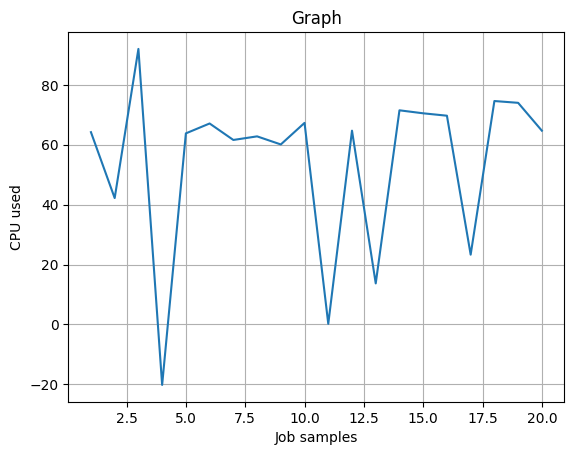

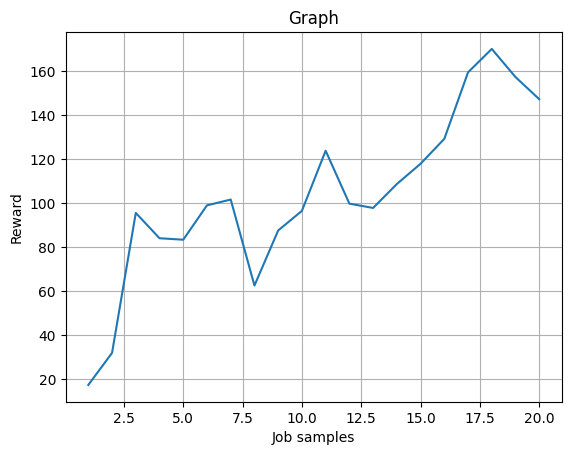

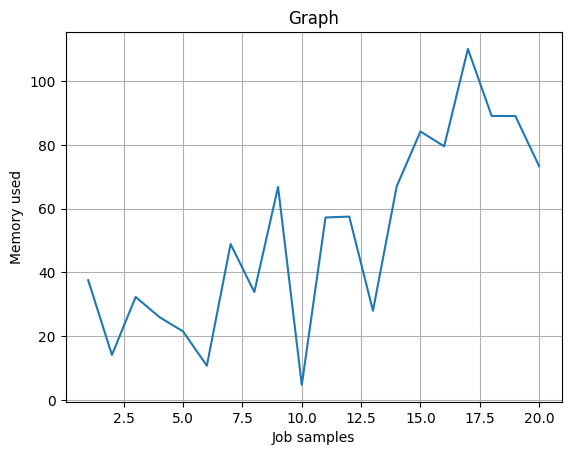

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.DataFrame(df)

# create a line graph
plt.plot(df1['Job samples'], df1['CPU used'])
plt.grid(True)
# add labels and title
plt.xlabel('Job samples')
plt.ylabel('CPU used')
plt.title('Graph')

# display the graph
plt.show()

#graph2
# create a line graph
plt.plot(df1['Job samples'], df1['Reward'])
plt.grid(True)
# add labels and title
plt.xlabel('Job samples')
plt.ylabel('Reward')
plt.title('Graph')

# display the graph
plt.show()
#graph3
# # create a line graph
plt.plot(df1['Job samples'], df1['Memory used'])
plt.grid(True)
# # add labels and title
plt.xlabel('Job samples')
plt.ylabel('Memory used')
plt.title('Graph')

# # display the graph
plt.show()

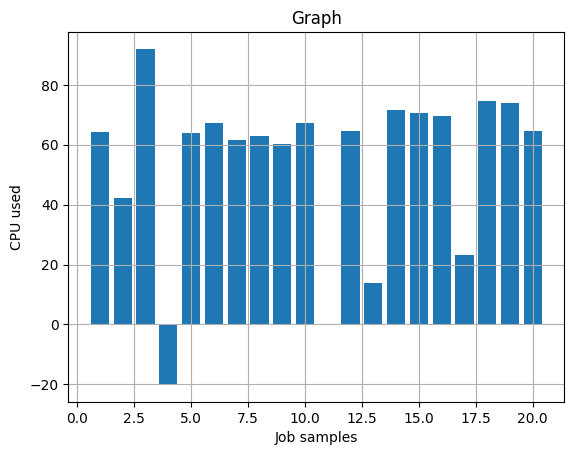

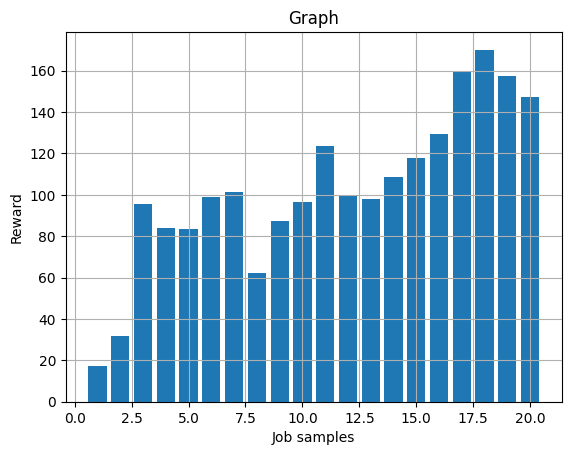

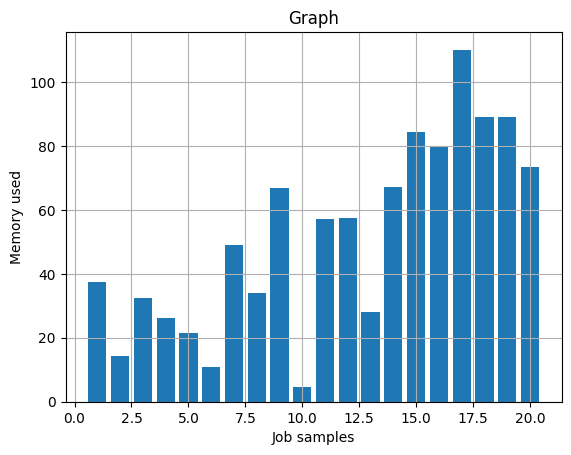

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.DataFrame(df)

# create a line graph
plt.bar(df1['Job samples'], df1['CPU used'])
plt.grid(True)
# add labels and title
plt.xlabel('Job samples')
plt.ylabel('CPU used')
plt.title('Graph')

# display the graph
plt.show()

#graph2
# create a line graph
plt.bar(df1['Job samples'], df1['Reward'])
plt.grid(True)
# add labels and title
plt.xlabel('Job samples')
plt.ylabel('Reward')
plt.title('Graph')

# display the graph
plt.show()
#graph3
# # create a line graph
plt.bar(df1['Job samples'], df1['Memory used'])
plt.grid(True)
# # add labels and title
plt.xlabel('Job samples')
plt.ylabel('Memory used')
plt.title('Graph')

# # display the graph
plt.show()